# Русская служба RFI: сбор и анализ данных

## Импорт библиотек

In [ ]:
!pip install fake_useragent
!pip install --upgrade urllib3
!pip install beautifulsoup4
!pip install wordcloud

In [ ]:
import logging
import os
import csv
import time
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from dataclasses import dataclass
from typing import List
import urllib.parse

import ast
import string
import re
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from IPython.display import display

%matplotlib inline

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (5, 3)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

## Скрапинг и парсинг новостных статей с сайта RFI

In [ ]:
@dataclass
class Article:
    """A class representing an individual publication on the news site."""

    url: str = None
    topic: str = None
    optional_tag: str = None
    title: str = None
    summary: str = None
    full_text: str = None
    pub_datetime: str = None
    reading_time: str = None
    content_tags: List[str] = None

In [ ]:
logger = logging.getLogger("main_logger")
logger.setLevel(logging.DEBUG)

log_format = "%(asctime)s - %(funcName)s: %(lineno)d - %(levelname)s: %(message)s"
formatter = logging.Formatter(log_format, datefmt="%H:%M:%S")

file_handler = logging.FileHandler("/content/logs.log", mode="a")
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)


def get_archive_urls(archive_href, base_url="https://www.rfi.fr"):
    """
    Fetches URLs of daily publication archives from an archive for a specific year.

    Args:
      archive_url (str): The URL of the page with monthly archives for a specific year to scrape.

    Returns:
      List[str]: A list containing daily archive URLs from each month of the year.
    """

    try:
        archive_response = requests.get(
            base_url + archive_href, headers={"User-Agent": UserAgent().chrome}
        )
        archive_tree = BeautifulSoup(archive_response.content, "html.parser")

        monthly_urls = [
            day.get("href")
            for day in archive_tree.find_all(
                "a", {"class": "o-archive-month__days__day__link"}
            )
        ]

        logger.info(
            f"Retrieved {len(monthly_urls)} URLs from {base_url + archive_href}"
        )
        return monthly_urls

    except requests.exceptions.RequestException as e:
        logger.error(f"HTTP request to {base_url + archive_href} failed: {e}")
        return []


def get_articles(monthly_urls, base_url="https://www.rfi.fr"):
    """
    Fetches publication URLs from daily archive pages.

    Args:
      monthly_urls (List[str]): A list of URLs corresponding to daily archive pages
                              with links to publications for a specific day.

    Returns:
      List[str]: A list containing URLs to all the available publications for a year.
    """

    articles = []

    for day_href in tqdm(monthly_urls):
        day_url = base_url + day_href

        try:
            day_response = requests.get(
                day_url, headers={"User-Agent": UserAgent().chrome}
            )

            time.sleep(2)

            day_tree = BeautifulSoup(day_response.content, "html.parser")
            day_articles = [
                entry.find("a", {"class": "a-archive-link"}).get("href")
                for entry in day_tree.find_all(
                    "li", {"class": "o-archive-day__list__entry"}
                )
            ]
            logger.info(f"Retrieved {len(day_articles)} URLs from {day_href}")
            articles.extend(day_articles)

        except requests.exceptions.RequestException as e:
            logger.error(f"HTTP request to {day_url} failed: {e}")
            day_articles = []
            articles.extend(day_articles)

    logger.info(f"Retrieved {len(articles)} URLs in total")
    return articles


def parse_articles_csv(href_list, output_file, base_url="https://www.rfi.fr"):
    """
    Parses information from individual publication pages.

    Args:
      href_list (List[str]): A list of publication URLs to parse.

    Returns:
      List[Article]: A list of Article objects,
                    each containing parsed information from the corresponding publication URL.
    """

    is_new_file = not os.path.exists(output_file)

    with open(output_file, "a", newline="") as csv_file:

        fieldnames = [
            "url",
            "topic",
            "optional_tag",
            "title",
            "summary",
            "full_text",
            "pub_datetime",
            "reading_time",
            "content_tags",
        ]

        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        if is_new_file:
            writer.writeheader()

        for article_href in tqdm(href_list):
            article_url = base_url + article_href
            article_response = requests.get(
                article_url, headers={"User-Agent": UserAgent().chrome}
            )

            time.sleep(2)

            if article_response.status_code == 200:
                article = Article()
                tree = BeautifulSoup(article_response.content, "html.parser")
                article.url = urllib.parse.unquote(article_url)


                try:
                    article.topic = tree.find_all(
                        "a", {"class": "m-breadcrumb__list__item__link"}
                    )[-1].text

                except Exception as e:
                    logger.warning(f"Upon TOPIC parsing: {e}")
                    article.topic = None


                try:
                    article.optional_tag = (
                        tree.find("div", {"class": "t-content__section a-tag"})

                        .find("span", {"class": "a-tag__wrapper"})
                        .text.strip()
                    )

                except Exception as e:
                    logger.warning(f"Upon OPTIONAL_TAGS parsing: {e}")
                    article.optional_tag = None


                try:
                    article.title = tree.find(
                        "h1", {"class": "t-content__title a-page-title"}
                    ).text

                except Exception as e:
                    logger.warning(f"Upon TITLE parsing: {e}")
                    article.title = None


                try:
                    article.summary = tree.find(
                        "p", {"class": "t-content__chapo"}
                    ).text.strip()

                except Exception as e:
                    logger.warning(f"Upon SUMMARY parsing: {e}")
                    article.summary = None

                self_promo = tree.find("div", {"class": "o-self-promo"})
                if self_promo:
                    self_promo.extract()


                try:
                    full_text = tree.find(
                        "div", {"class": "t-content__body u-clearfix"}
                    )
                    article.full_text = "\n".join(
                        [p.text for p in full_text.find_all("p")]
                    )

                except Exception as e:
                    logger.warning(f"Upon FULL_TEXT parsing: {e}")
                    article.full_text = None


                try:
                    article.pub_datetime = tree.find("time").get("datetime")

                except Exception as e:
                    logger.warning(f"Upon PUB_DATETIME parsing: {e}")
                    article.pub_datetime = None


                try:
                    article.reading_time = tree.find(
                        "div", {"class": "a-reading-time"}
                    ).text.strip()

                except Exception as e:
                    logger.warning(f"Upon READING_TIME parsing: {e}")
                    article.reading_time = None


                try:
                    content_tags = tree.find(
                        "div", {"class": "t-content__tags"}
                    ).find_all("a", {"class": "a-hot-tag"})
                    article.content_tags = [tag.get("title") for tag in content_tags]

                except Exception as e:
                    logger.warning(f"Upon CONTENT_TAGS parsing: {e}")
                    article.content_tags = None


                writer.writerow(
                    {
                        "url": article.url,
                        "topic": article.topic,
                        "optional_tag": article.optional_tag,
                        "title": article.title,
                        "summary": article.summary,
                        "full_text": article.full_text,
                        "pub_datetime": article.pub_datetime,
                        "reading_time": article.reading_time,
                        "content_tags": article.content_tags,
                    }
                )

In [ ]:
parse_articles_csv(get_articles(get_archive_urls('/ru/aрхивы/2023/')), '/data/articles_23.csv')

In [ ]:
parse_articles_csv(get_articles(get_archive_urls('/ru/aрхивы/2022/')), '/data/articles_22.csv')

In [ ]:
parse_articles_csv(get_articles(get_archive_urls('/ru/aрхивы/2021/')), '/data/articles_21.csv')

## Разведочный анализ данных

### Загрузка датасетов и общее исследование данных

In [ ]:
def clean_dataset(df):
    """Cleans a DataFrame by removing:
    - publications of videos
    - live reports
    - podcasts
    - auxiliary column optional_tag
    """
    df = df[~df["full_text"].isna()]
    df = df[
        ~(
            df["optional_tag"].fillna("").str.contains("онлайн", case=False)
            | df["title"].str.contains("онлайн", case=False)
        )
    ]
    df = df[
        ~df["content_tags"]
        .fillna("[]")
        .apply(ast.literal_eval)
        .apply(
            lambda tags: any(word in tags for word in [
                             "Видео", "Онлайн", "Интервью"])
        )
    ]
    df = df[~df["url"].str.contains(".*подкасты.*")]
    df = df.drop(columns=["optional_tag"])
    return df


def gradient_color(val, cmap_name="YlOrRd"):
    """Generate style for background color with a gradient effect based on a value."""
    if val > 0:
        norm = plt.Normalize(0, 5)
        cmap = plt.get_cmap(cmap_name)
        rgba = cmap(norm(val))
        return f"background-color: rgba{str(tuple(int(255 * x) for x in rgba[:3]))};"
    else:
        return ""

__Данные разделены на 3 таблицы, каждая из которых содержит данные о новостных публикациях за один год: 2023, 2022 и 2021.__

Среди публикаций на сайте RFI есть посты с подкастами, фото/видео- и онлайн-репортажами, предварительно очистим датасет, оставив (предположительно) только новостные статьи.

In [ ]:
data_23 = pd.read_csv('https://raw.githubusercontent.com/ErmakovaAna/rfi-news-bot/main/data/articles_23.csv')
data_22 = pd.read_csv('https://raw.githubusercontent.com/ErmakovaAna/rfi-news-bot/main/data/articles_22.csv')
data_21 = pd.read_csv('https://raw.githubusercontent.com/ErmakovaAna/rfi-news-bot/main/data/articles_21.csv')

In [ ]:
articles_23 = clean_dataset(data_23)
articles_22 = clean_dataset(data_22)
articles_21 = clean_dataset(data_21)

Доля публикаций, которые остались после предварительной фильтрации данных:

- 2023 год: *74,02%*
- 2022 год: *76,48%*
- 2021 год: *94,12%*

In [ ]:
articles_23.shape[0] / data_23.shape[0] * 100, articles_22.shape[0] / \
    data_22.shape[0] * 100, articles_21.shape[0] / data_21.shape[0] * 100

(74.02805611222445, 76.48628048780488, 94.12310547479122)

In [ ]:
nans = pd.concat(
    [
        pd.DataFrame(
            data={
                col: [
                    articles_23[col].isna().sum(),
                    articles_23[col].isna().sum() / len(articles_23) * 100,
                ]
                for col in articles_23.columns
            }
        ).T,
        pd.DataFrame(
            data={
                col: [
                    articles_22[col].isna().sum(),
                    articles_22[col].isna().sum() / len(articles_22) * 100,
                ]
                for col in articles_22.columns
            }
        ).T,
        pd.DataFrame(
            data={
                col: [
                    articles_21[col].isna().sum(),
                    articles_21[col].isna().sum() / len(articles_21) * 100,
                ]
                for col in articles_21.columns
            }
        ).T,
    ],
    axis=1,
)
nans.index = pd.Index(nans.index, name="Columns : ")
nans.columns = pd.MultiIndex.from_product(
    [["2023", "2022", "2021"], ["num_na", "percent"]],
    names=["Year : ", "NaN Statistic :"],
)

nans.style.applymap(
    gradient_color, subset=pd.IndexSlice[:, pd.IndexSlice[:, "percent"]]
)

В столбцах  `topic` (тематический раздел), `summary` (лид-абзац статьи) и `content_tags` (ключевые слова) есть малое количество пропусков (менее 1%). Поскольку пропусков немного, а сами столбцы могут быть важны для дальнейшего анализа, строки с пропусками в них удаляются.

В столбце `reading_time` большое количество пропусков (суммарно в трех таблицах примерно 50%). Больше всего пропусков в датасете за 2021 год, потому что указывать время чтения статьи на сайте начали примерно с конца июня.

В дальнейшем в качестве стратегии работы с пропущенными значениями в столбце `reading_time` попробуем обучить модель для заполнения пропусков.

In [ ]:
articles_23 = articles_23.dropna(subset=["topic", "summary", "content_tags"])
articles_22 = articles_22.dropna(subset=["topic", "summary", "content_tags"])
articles_21 = articles_21.dropna(subset=["topic", "summary", "content_tags"])

In [ ]:
dfs = [articles_23, articles_22, articles_21]
years = ["2023", "2022", "2021"]

После проведения первичной обработки данных мы получили общий датасет, включающий __6886 записи__.

Каждому объекту в датасете соответствуют __8 атрибутов__:

- __*url*__ — URL статьи;

- __*topic*__ — тематический раздел, в котором опубликована статья на сайте;

- __*title*__ — заголовок статьи;

- __*summary*__ — лид-абзац статьи;

- __*full_text*__ — основной текст статьи;

- __*pub_datetime*__ — дата и время публикации статьи;

- __*reading_time*__ — время чтения статьи;

- __*content_tags*__ — список ключевых слов, связанных с содержанием текста статьи.

Все атрибуты представлены строковыми значениями.

In [ ]:
articles_full = pd.concat(
    [articles_23, articles_22, articles_21], axis=0, ignore_index=True)
articles_full.shape

(6886, 8)

In [ ]:
articles_full.head()

url    topic  \
0  https://www.rfi.fr/ru/франция/20231106-атака-х...  Франция   
1  https://www.rfi.fr/ru/франция/20231106-во-фран...  Франция   
2  https://www.rfi.fr/ru/россия/20231106-илью-яши...   Россия   
3  https://www.rfi.fr/ru/в-мире/20231106-в-цахал-...   В мире   
4  https://www.rfi.fr/ru/франция/20231106-северно...  Франция   

                                               title  \
0  Атака ХАМАС на Израиль: по последним данным, 4...   
1  Во французском Сенате начались дебаты по спорн...   
2  Илью Яшина обвинили в отсутствии маркировки «и...   
3  В ЦАХАЛ заявили, что израильские войска раздел...   
4  Северное сияние можно было наблюдать над Франц...   

                                             summary  \
0  По уточненным данным, число погибших французов...   
1  Правительство Франции обещало представить прое...   
2  Находящийся в заключении российский оппозицион...   
3  Израильская армия продолжает наземные операции...   
4  Вечером в воскресенье во многих регионах Франц...   

                                           full_text  \
0  Ранее власти Франции сообщали о 39 погибших и ...   
1  Законопроект об иммиграции сначала проходит об...   
2  «8 ноября меня в СИЗО навестит государственный...   
3  Официальный представитель ЦАХАЛ Даниэль Хагари...   
4  Полярные сияния, возникающие из-за вспышек на ...   

                pub_datetime reading_time  \
0  2023-11-06T09:44:15+00:00        1 мин   
1  2023-11-06T13:12:06+00:00        2 мин   
2  2023-11-06T11:49:57+00:00        2 мин   
3  2023-11-06T10:56:02+00:00        4 мин   
4  2023-11-06T13:26:35+00:00        2 мин   

                                        content_tags  
0  ['Франция', 'Израиль', 'ХАМАС', 'Заложники', '...  
1  ['Франция', 'Парламент Франции', 'Законодатель...  
2  ['Россия', 'Политзаключенные', 'Илья Яшин', 'Т...  
3  ['Израиль', 'сектор Газа', 'ХАМАС', 'Война', '...  
4                      ['Франция', 'Космос', 'Фото']

### __topic__: Тематический раздел

В общем наборе данных представлены статьи распределены по __*12 тематическим категориям*__.





In [ ]:
articles_full["topic"].value_counts().index

Index(['Россия', 'Франция', 'В мире', 'Европа', 'Украина',
       'Культура & Стиль жизни', 'Спорт', 'Кавказ', 'Центральная Азия',
       'Общий', 'Права человека', 'Общество'],
      dtype='object')

In [ ]:
counts_23 = articles_23["topic"].value_counts()
counts_22 = articles_22["topic"].value_counts()
counts_21 = articles_21["topic"].value_counts()

topic_counts = (
    pd.DataFrame({"2023": counts_23, "2022": counts_22, "2021": counts_21})
    .fillna(0)
    .astype(int)
)
topic_counts["total_count"] = topic_counts.iloc[:, :3].sum(axis=1)
topic_counts = topic_counts.sort_values(by="total_count", ascending=False)

percentage = pd.DataFrame((topic_counts["total_count"] / 7177 * 100))
topic_counts = pd.concat([topic_counts, percentage], axis=1, keys=["num", "%"])

topic_counts.style.set_caption(
    "Number of articles over the topics and years"
).set_table_styles(
    [{"selector": "caption", "props": [
        ("font-size", "18px"), ("font-weight", "bold")]}]
)

_______
__Распределение категорий__
> Статьи распределены неравномерно между различными тематическими разделами. Большинство, около 83% всех статей, относится к 5 наиболее популярным категориям из 12: *Россия*, *Франция*, *В мире*, *Европа* и *Украина*.






### __title__: Заголовок статьи

In [ ]:
def count_title_stats(title):
    """Counts the number of tokens and characters in a title."""
    clean_title = re.sub(r"[^\w\s]", "", title)
    token_count = len(clean_title.split())

    char_count = len(list(filter(lambda x: x != " ", clean_title)))

    return token_count, char_count

Заголовки статей представленны в данных строками. Создаем на основе строк с заголовками статей новые признаки для объектов:

- `title_toks`: количество токенов в заголовке статьи;

- `title_chars`: количество символов без пробелов в заголовке статьи.

In [ ]:
articles_full['title_toks'] = articles_full['title'].apply(
    lambda x: count_title_stats(x)[0])
articles_full['title_chars'] = articles_full['title'].apply(
    lambda x: count_title_stats(x)[1])

for df in dfs:
    df['title_toks'] = df['title'].apply(lambda x: count_title_stats(x)[0])
    df['title_chars'] = df['title'].apply(lambda x: count_title_stats(x)[1])

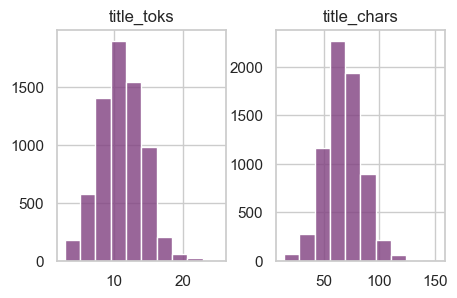

In [ ]:
articles_full[['title_toks', 'title_chars']].hist(color=(0.5, 0.25, 0.5, 0.8));

In [ ]:
for data in articles_full[["title_toks", "title_chars"]]:
    data = articles_full["title_chars"]
    stat, p_value = stats.shapiro(data)

    print(f"statistic: {stat}")
    print(f"p-value: {p_value}")

    if p_value < 0.05:
        print("The data is not normally distributed\n")
    else:
        print("The data is normally distributed\n")

statistic: 0.9958977103233337
p-value: 4.990804861396136e-13
The data is not normally distributed

statistic: 0.9958977103233337
p-value: 4.990804861396136e-13
The data is not normally distributed



________
Распределения длины заголовков статей в токенах и в символах имеют сходство с нормальным распределением, что подтверждается высоким значением статистики Шапиро-Уилка, близким к 1.

Однако p-value оказывается ниже стандартного уровня значимости, что указывает на то, что данные не соответствуют нулевой гипотезе о нормальном распределении.

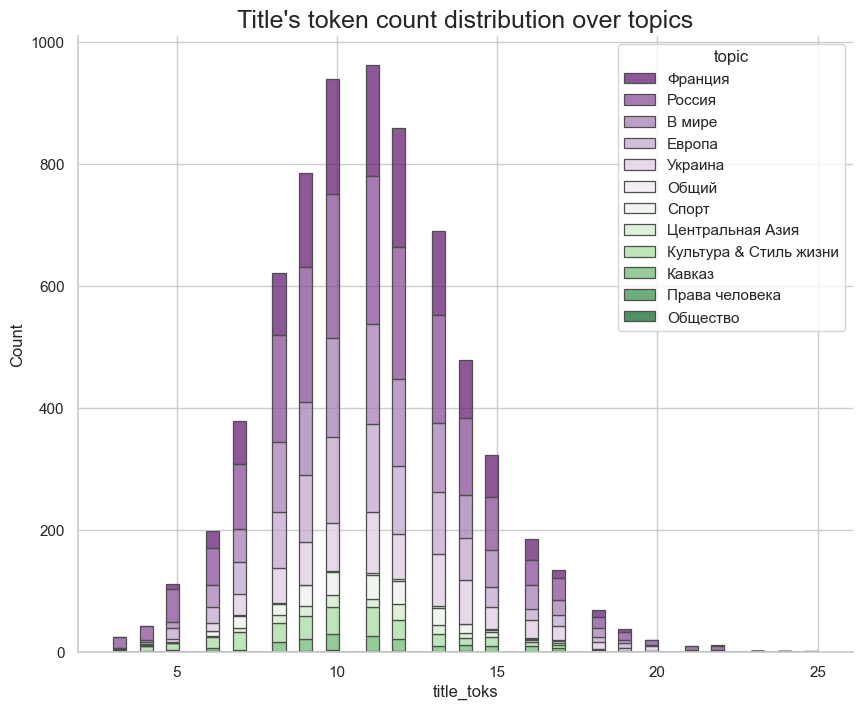

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
sns.despine(fig)

hist = sns.histplot(
    articles_full,
    x="title_toks",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="PRGn",
    linewidth=0.9,
)
hist.axes.set_title("Title's token count distribution over topics", fontsize=18);

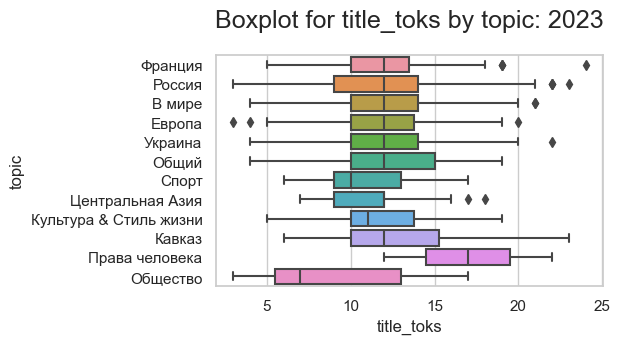

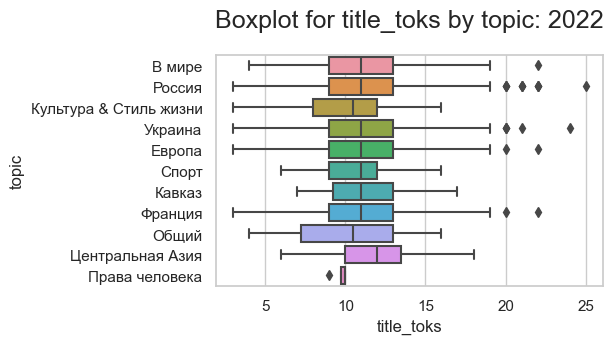

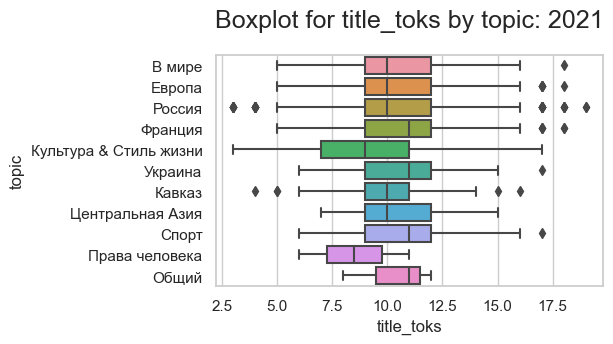

In [ ]:
for df, year in zip(dfs, years):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=100)
    sns.boxplot(x="title_toks", y="topic", data=df, orient="h", ax=ax)
    plt.title(f"Boxplot for title_toks by topic: {year}", fontsize=18, pad=20);

______
__Распределение длины заголовков в токенах__

> В данных о длине заголовков в токенах наблюдается наличие выбросов. Чаще эти выбросы проявляются как значимые отклонения в сторону бóльших значений.

> Наиболее постоянная характеристика для длины заголовков в токенах — среднее значение.

> Заголовки из категорий с наибольшим количеством статей обычно более единообразны по числу токенов по сравнению с заголовками статей из меньших тематических разделов. В большинстве случаев их распределения характеризуются схожими средними значениями и диапазонами значений.

> Длины заголовков в токенах из малочисленных тематических разделов имеют статистические характеристики, которые различаются между собой и отличаются от более крупных категорий.


### __summary__: Краткое содержание статьи


In [ ]:
def count_summary_stats(summary):
    """Counts the number of tokens and characters in a summary."""
    summary_wo_punc = re.sub(r"[^\w\s]", "", summary)
    clean_summary = summary_wo_punc.replace("\xa0", " ")
    token_count = len(clean_summary.split())

    char_count = len(list(filter(lambda x: x != " ", clean_summary)))

    return token_count, char_count

На основе атрибута `len_summary` — общее количество токенов в лид-абзаце (вводном абзаце к статье) создаем два новых признака:

- `summary_toks`: количество токенов;

- `summary_chars`: количество символов без учета пробелов и управляющих символов.

In [ ]:
articles_full["summary_toks"] = articles_full["summary"].apply(
    lambda x: count_summary_stats(x)[0]
)
articles_full["summary_chars"] = articles_full["summary"].apply(
    lambda x: count_summary_stats(x)[1]
)

for df in dfs:
    df["summary_toks"] = df["summary"].apply(lambda x: count_summary_stats(x)[0])
    df["summary_chars"] = df["summary"].apply(lambda x: count_summary_stats(x)[1])

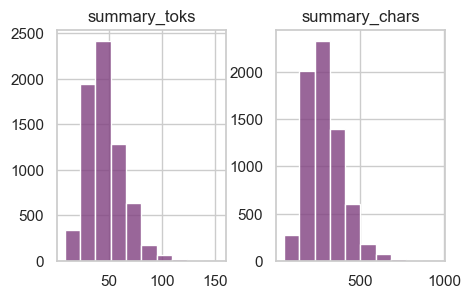

In [ ]:
articles_full[['summary_toks', 'summary_chars']].hist(color=(0.5, 0.25, 0.5, 0.8));

_____
На графиках распределений количества токенов и количества символов без пробелов в вводных абзацах к публикациям отмечается смещение, но, по-видимому, без значительных выбросов, поскольку мы не наблюдаем тяжелых хвостов в распределениях.

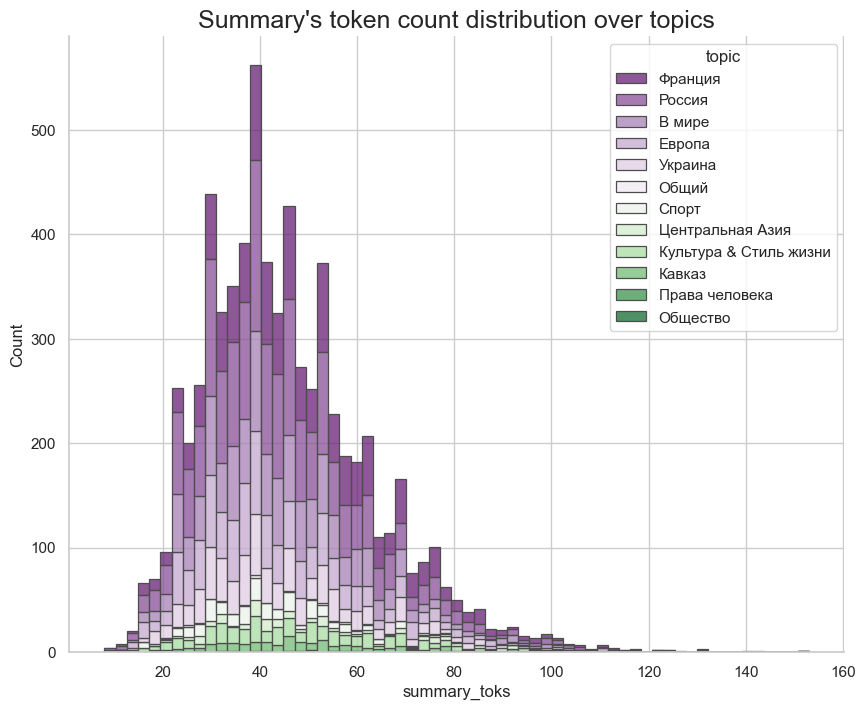

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
sns.despine(fig)

hist = sns.histplot(
    articles_full,
    x="summary_toks",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="PRGn",
    linewidth=0.9,
)
hist.axes.set_title("Summary's token count distribution over topics", fontsize=18);

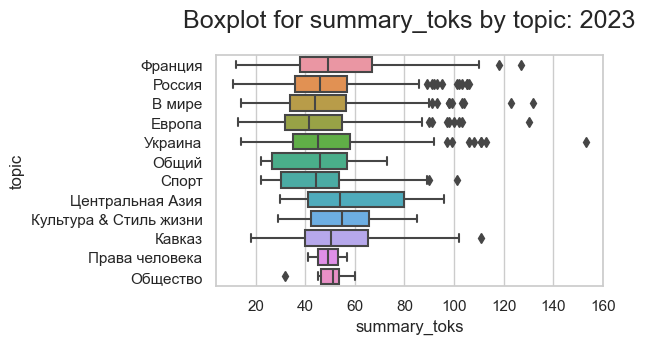

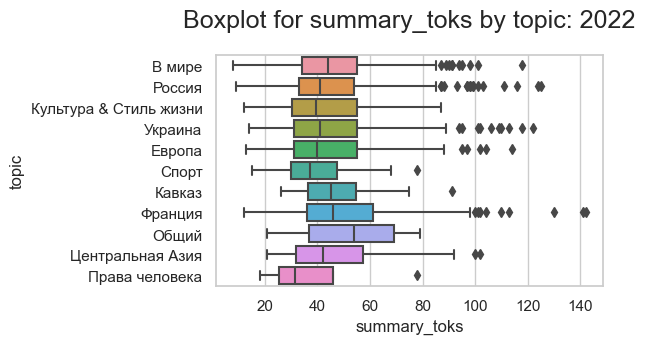

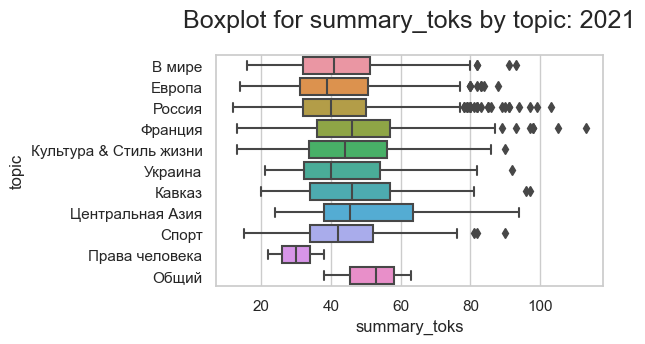

In [ ]:
for df, year in zip(dfs, years):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=100)
    sns.boxplot(x="summary_toks", y="topic", data=df, orient="h", ax=ax)
    plt.title(f"Boxplot for summary_toks by topic: {year}", fontsize=18, pad=20);

____
__Распределение количества токенов в лид-абзацах к публикациям__

> В распределениях количества токенов в вводных абзацах наблюдаются выбросы в сторону бóльших значений. Большее количество значений существенно отклоняющихся от среднего наблюдается в тематических разделах с наибольшим объемом статей.

> Средние значения признака и диапазоны значений различаются между разными тематическими разделами. Однако стоит отметить некоторую степень схожести в распределениях длины лид-абзацев в крупных категориях, особенно в публикациях 2022 года.

### __full_text__: Основной текст статьи

In [ ]:
def count_text_stats(full_text):
    """ "Counts the number of tokens and characters in a main text."""
    text_wo_punc = re.sub(r"[^\w\s]", "", full_text)
    clean_text = text_wo_punc.replace("\xa0", " ").replace("\n", " ")
    token_count = len(clean_text.split())

    char_count = len(list(filter(lambda x: x != " ", clean_text)))

    return token_count, char_count

Создаем признаки на основе базовых характеристик основного текста:

- `full_text_toks`: количество токенов в основном тексте;

- `full_text_chars`: количество символов (без учета пробелов и управляющих символов) в основном тексте.

In [ ]:
articles_full["full_text_toks"] = articles_full["full_text"].apply(
    lambda x: count_text_stats(x)[0]
)
articles_full["full_text_chars"] = articles_full["full_text"].apply(
    lambda x: count_text_stats(x)[1]
)

for df in dfs:
    df["full_text_toks"] = df["full_text"].apply(lambda x: count_text_stats(x)[0])
    df["full_text_chars"] = df["full_text"].apply(lambda x: count_text_stats(x)[1])

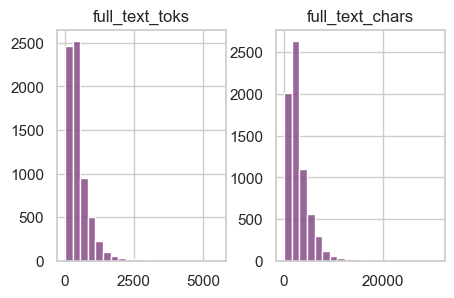

In [ ]:
articles_full[['full_text_toks', 'full_text_chars']].hist(bins=20, color=(0.5, 0.25, 0.5, 0.8));

____
Прежде всего заметим, что в распределениях количества токенов и символов в основном тексте публикаций есть значения близкие к 0. Интуитивно кажется, что новостные статьи не могут быть такими краткими. Скорее всего это публикации фото/видео/подкастов, которые остались после первичной фильтрации.

Для начала попробуем удалить из данных объекты, у которых количество токенов в основном тексте меньше, чем в лид-абзаце. В общем датасете такие записей 29.

In [ ]:
articles_full[articles_full['full_text_toks'] < articles_full['summary_toks']].shape[0]

29

In [ ]:
articles_full = articles_full.drop(
    articles_full[articles_full["full_text_toks"] < articles_full["summary_toks"]].index
)

articles_23 = articles_23.drop(
    articles_23[articles_23["full_text_toks"] < articles_23["summary_toks"]].index
)
articles_22 = articles_22.drop(
    articles_22[articles_22["full_text_toks"] < articles_22["summary_toks"]].index
)
articles_21 = articles_21.drop(
    articles_21[articles_21["full_text_toks"] < articles_21["summary_toks"]].index
)

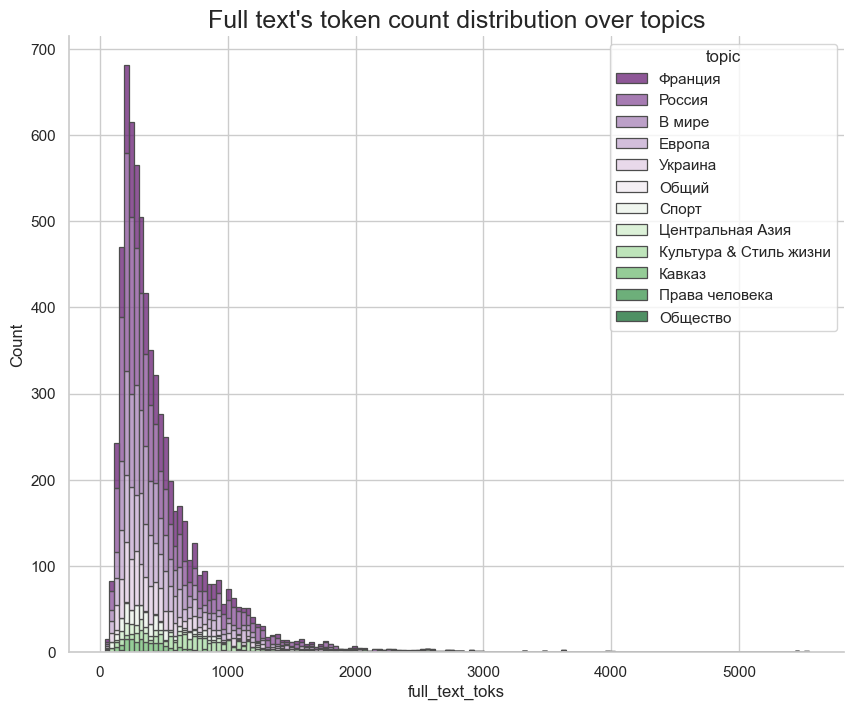

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
sns.despine(fig)

hist = sns.histplot(
    articles_full,
    x="full_text_toks",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="PRGn",
    linewidth=0.9,
)
hist.axes.set_title("Full text's token count distribution over topics", fontsize=18);

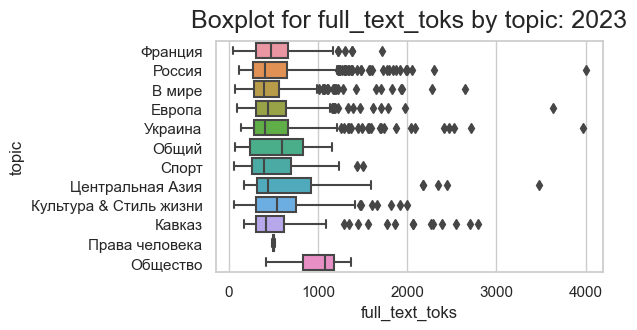

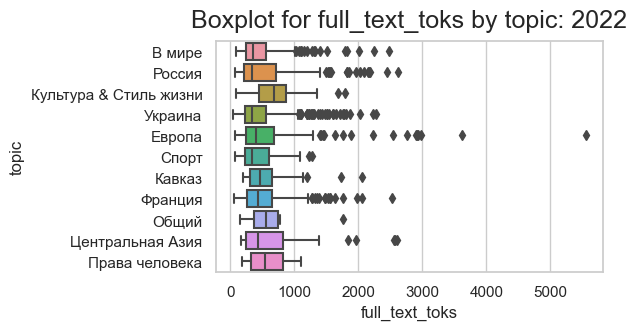

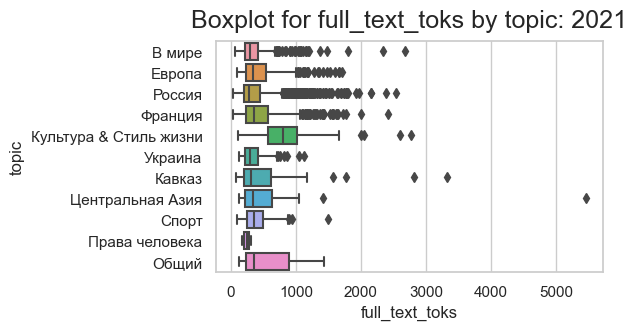

In [ ]:
for df, year in zip([articles_23, articles_22, articles_21], years):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=100)
    sns.boxplot(x="full_text_toks", y="topic", data=df, orient="h", ax=ax)
    plt.title(f"Boxplot for full_text_toks by topic: {year}", fontsize=18, pad=10);

______
__Распределение количества токенов в основном тексте__

> Распределения количества токенов в основном тексте статей сильно скошены с большим количеством статей, длина которых много больше среднего значения в соответствующей категории.  

> После дополнительной фильтрации по количеству токенов в тексте публикации, в данных все еще наблюдаются маленькие минимальные значения. В общем датасете минимальное значение по данному признаку — 36 токенов.

### __pub_datetime__: Дата и время публикации статьи

Дата публикации в столбце `pub_datetime` представлена в виде строки в формате ISO 8601. Чтобы получить значимые признаки для объектов извлекаем из этой строки:

- `year`: год публикации;

- `month`: месяц публикации;

- `weekday`: день недели, в который был опубликован пост на сайте.

In [ ]:
articles_full["pub_datetime"] = pd.to_datetime(articles_full["pub_datetime"])
articles_full["year"] = articles_full["pub_datetime"].dt.strftime("%Y")
articles_full["month"] = articles_full["pub_datetime"].dt.strftime("%B")
articles_full["weekday"] = articles_full["pub_datetime"].dt.strftime("%A")

for df in dfs:
    df["pub_datetime"] = pd.to_datetime(df["pub_datetime"])
    df["year"] = df["pub_datetime"].dt.strftime("%Y")
    df["month"] = df["pub_datetime"].dt.strftime("%B")
    df["weekday"] = df["pub_datetime"].dt.strftime("%A")

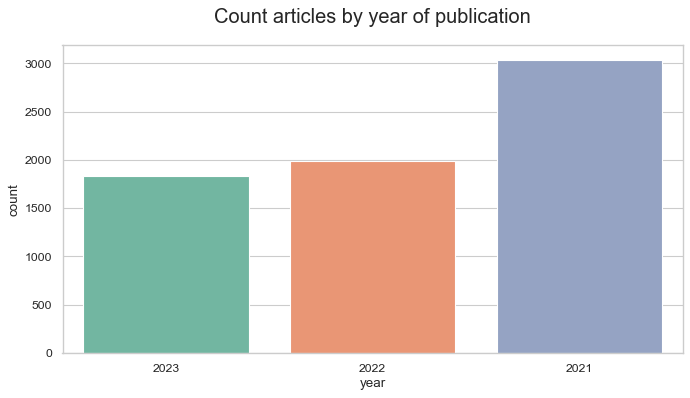

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=80)
for i, col in enumerate(["year"]):
    sns.countplot(
        x=articles_full[col],
        palette="Set2",
        ax=ax,
        order=articles_full[col].value_counts(ascending=True).index,
    )
ax.set_title("Count articles by year of publication", fontsize=18, pad=20);

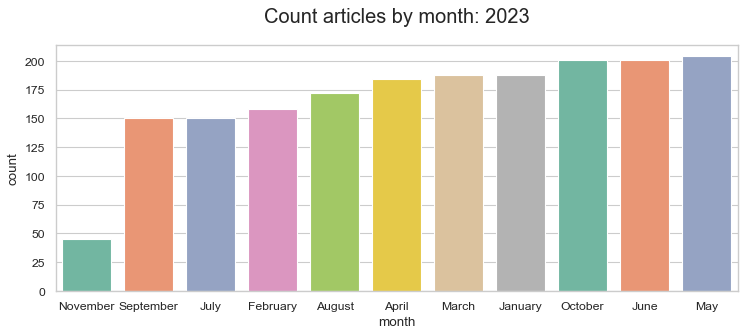

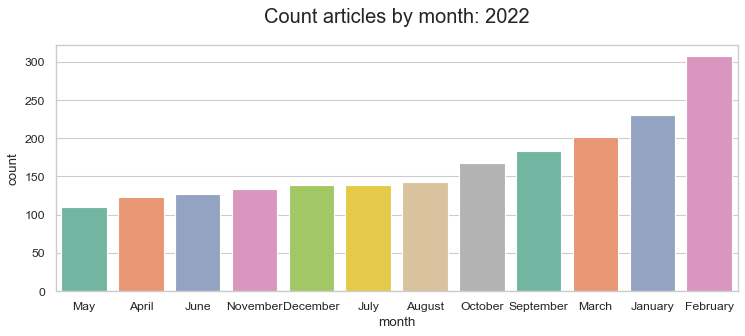

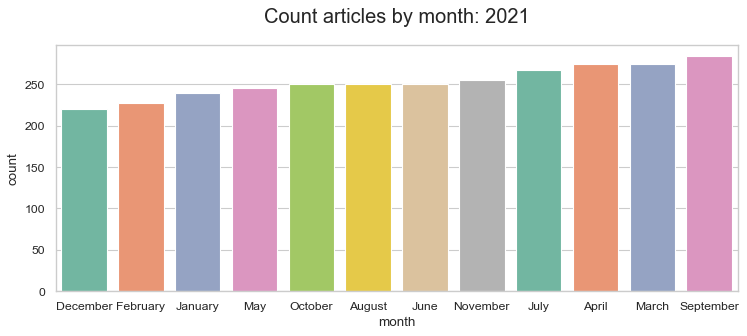

In [ ]:
for df, year in zip(dfs, years):
    fig, ax = plt.subplots(1, 1, figsize=(11, 4), dpi=80)
    for i, col in enumerate(["month"]):
        sns.countplot(
            x=df[col],
            palette="Set2",
            ax=ax,
            order=df[col].value_counts(ascending=True).index,
        )
    ax.set_title(f"Count articles by month: {year}", fontsize=18, pad=20);

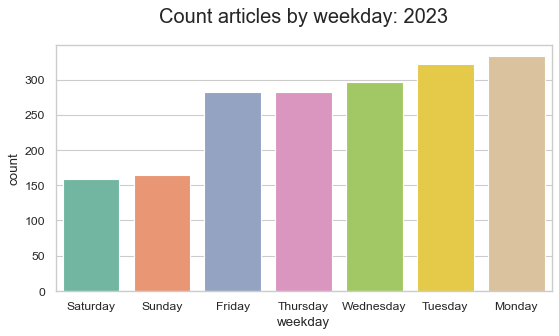

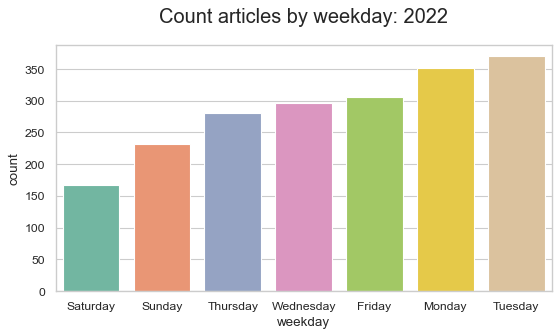

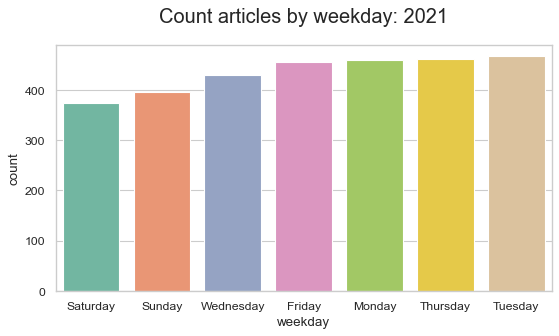

In [ ]:
for df, year in zip(dfs, years):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=80)
    for i, col in enumerate(["weekday"]):
        sns.countplot(
            x=df[col],
            palette="Set2",
            ax=ax,
            order=df[col].value_counts(ascending=True).index,
        )
    ax.set_title(f"Count articles by weekday: {year}", fontsize=18, pad=20);

_______
__Распределение данных по времени публикации__

> В датасете содержится больше всего данных за 2021 год, в то время как статей за 2022 год почти на 1000 объектов меньше. Учитывая, что сбор данных был выполнен в начале ноября 2023 года, за текущий год наблюдается наименьшее количество данных.

> Можно отметить близкое к равномерному распределение публикаций по месяцам в 2021 году. В то же время распределение количества публикаций по месяцам в 2022 году сильно отклоняется от равномерного. Кроме того, в 2022 году отмечается снижение общего количества данных по сравнению с 2021 годом в каждом месяце. Одной из причин этого может быть ранее отмеченное увеличение разнообразие контента на сайте с начала 2022 года контент, который публикуется на сайте более диверсифицированный (в начале исследования мы отфильтровали почти по 30% публикаций фото/видео/аудио-материалов из данных за 2022 и 2023 годы).

> Графики распределений количества статей по дням недели показывают, что в начале недели (понедельник, вторник) число публикаций наибольшее, а на выходных наблюдается снижение активности. При этом разница между количеством публикаций в начале и конце недели в 2021 году гораздо меньше, чем в 2022 и 2023 годах.

### __content_tags__: Теги (ключевые слова), связанные с содержанием статьи

In [48]:
articles_full["content_tags"] = articles_full["content_tags"].fillna("[]")
articles_full["content_tags"] = articles_full["content_tags"].apply(
    lambda x: ast.literal_eval(x)
)

В данных присутствуют 844 уникальных тега.



In [50]:
print(
    "Number of unique tags:     ",
    (len(articles_full["content_tags"].explode().unique())),
)
print("\n10 most frequent tags:")
articles_full["content_tags"].explode().value_counts()[:10]

Number of unique tags:      844

10 most frequent tags:


Россия                     3213
Франция                    2088
Нападение РФ на Украину    1566
Украина                    1540
Война                      1520
США                         802
Права человека              788
Политика                    749
Евросоюз                    734
Суд                         719
Name: content_tags, dtype: int64

Добавим в данные новый признак — `num_content_tags` — количество ключевых слов, связанных с содержанием основного текста статьи.

In [51]:
articles_full['num_content_tags'] = articles_full['content_tags'].apply(lambda x: len(x))

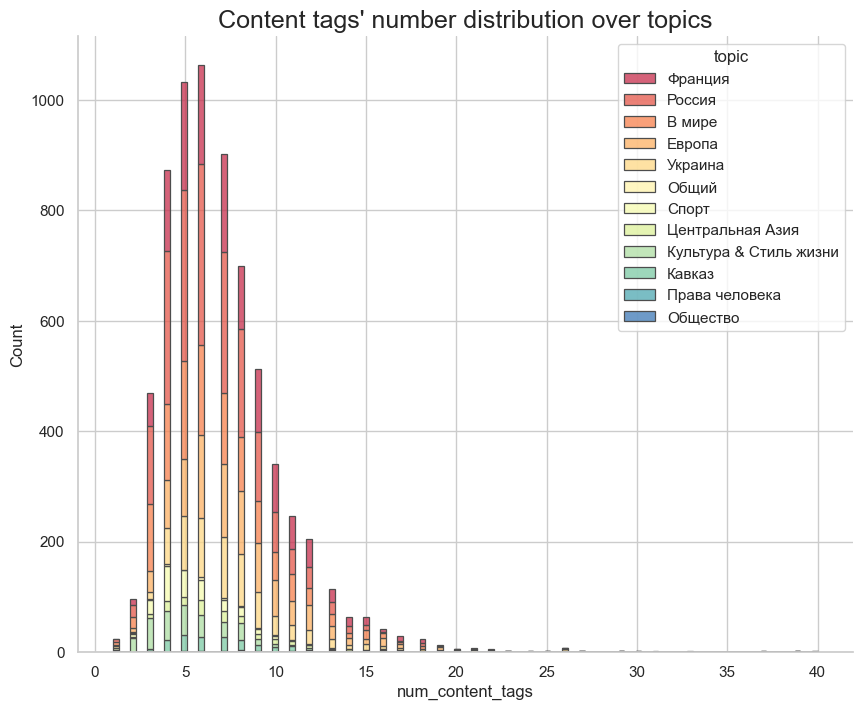

In [52]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
sns.despine(fig)

hist = sns.histplot(
    articles_full,
    x="num_content_tags",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="Spectral",
    linewidth=0.9,
)
hist.axes.set_title("Content tags' number distribution over topics", fontsize=18);

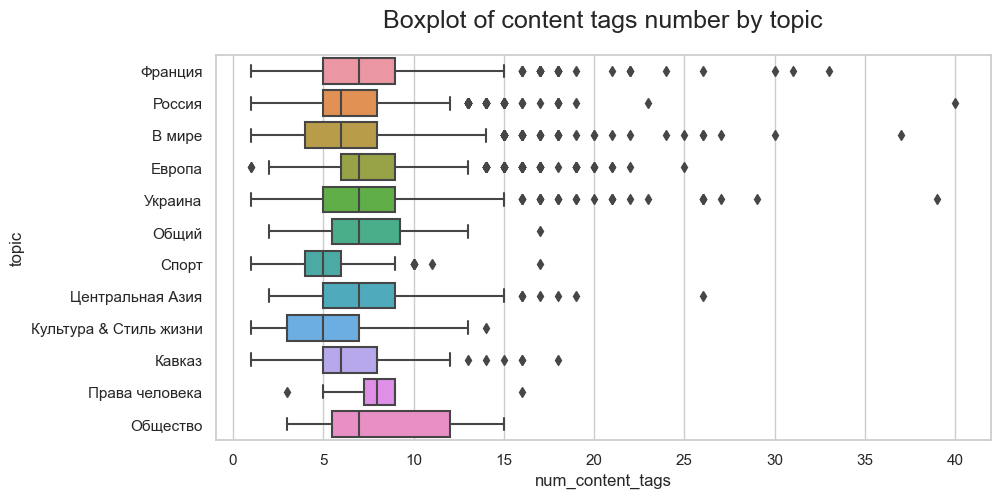

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
sns.boxplot(x="num_content_tags", y="topic", data=articles_full, orient="h", ax=ax)
plt.title("Boxplot of content tags number by topic", fontsize=18, pad=20);

_______
__Распределение количества ключевых слов__

> Распределение количества ключевых слов демонстрирует скос и большое количество значений, которые сильно превышают среднее значение. Этим данное распределение напоминает распределение количества токенов в основном тексте статьи. Предположительно, существует корреляция между объемом статьи и числом выделяемых ключевых слов (тегов), что могло бы объяснить сходство распределений.

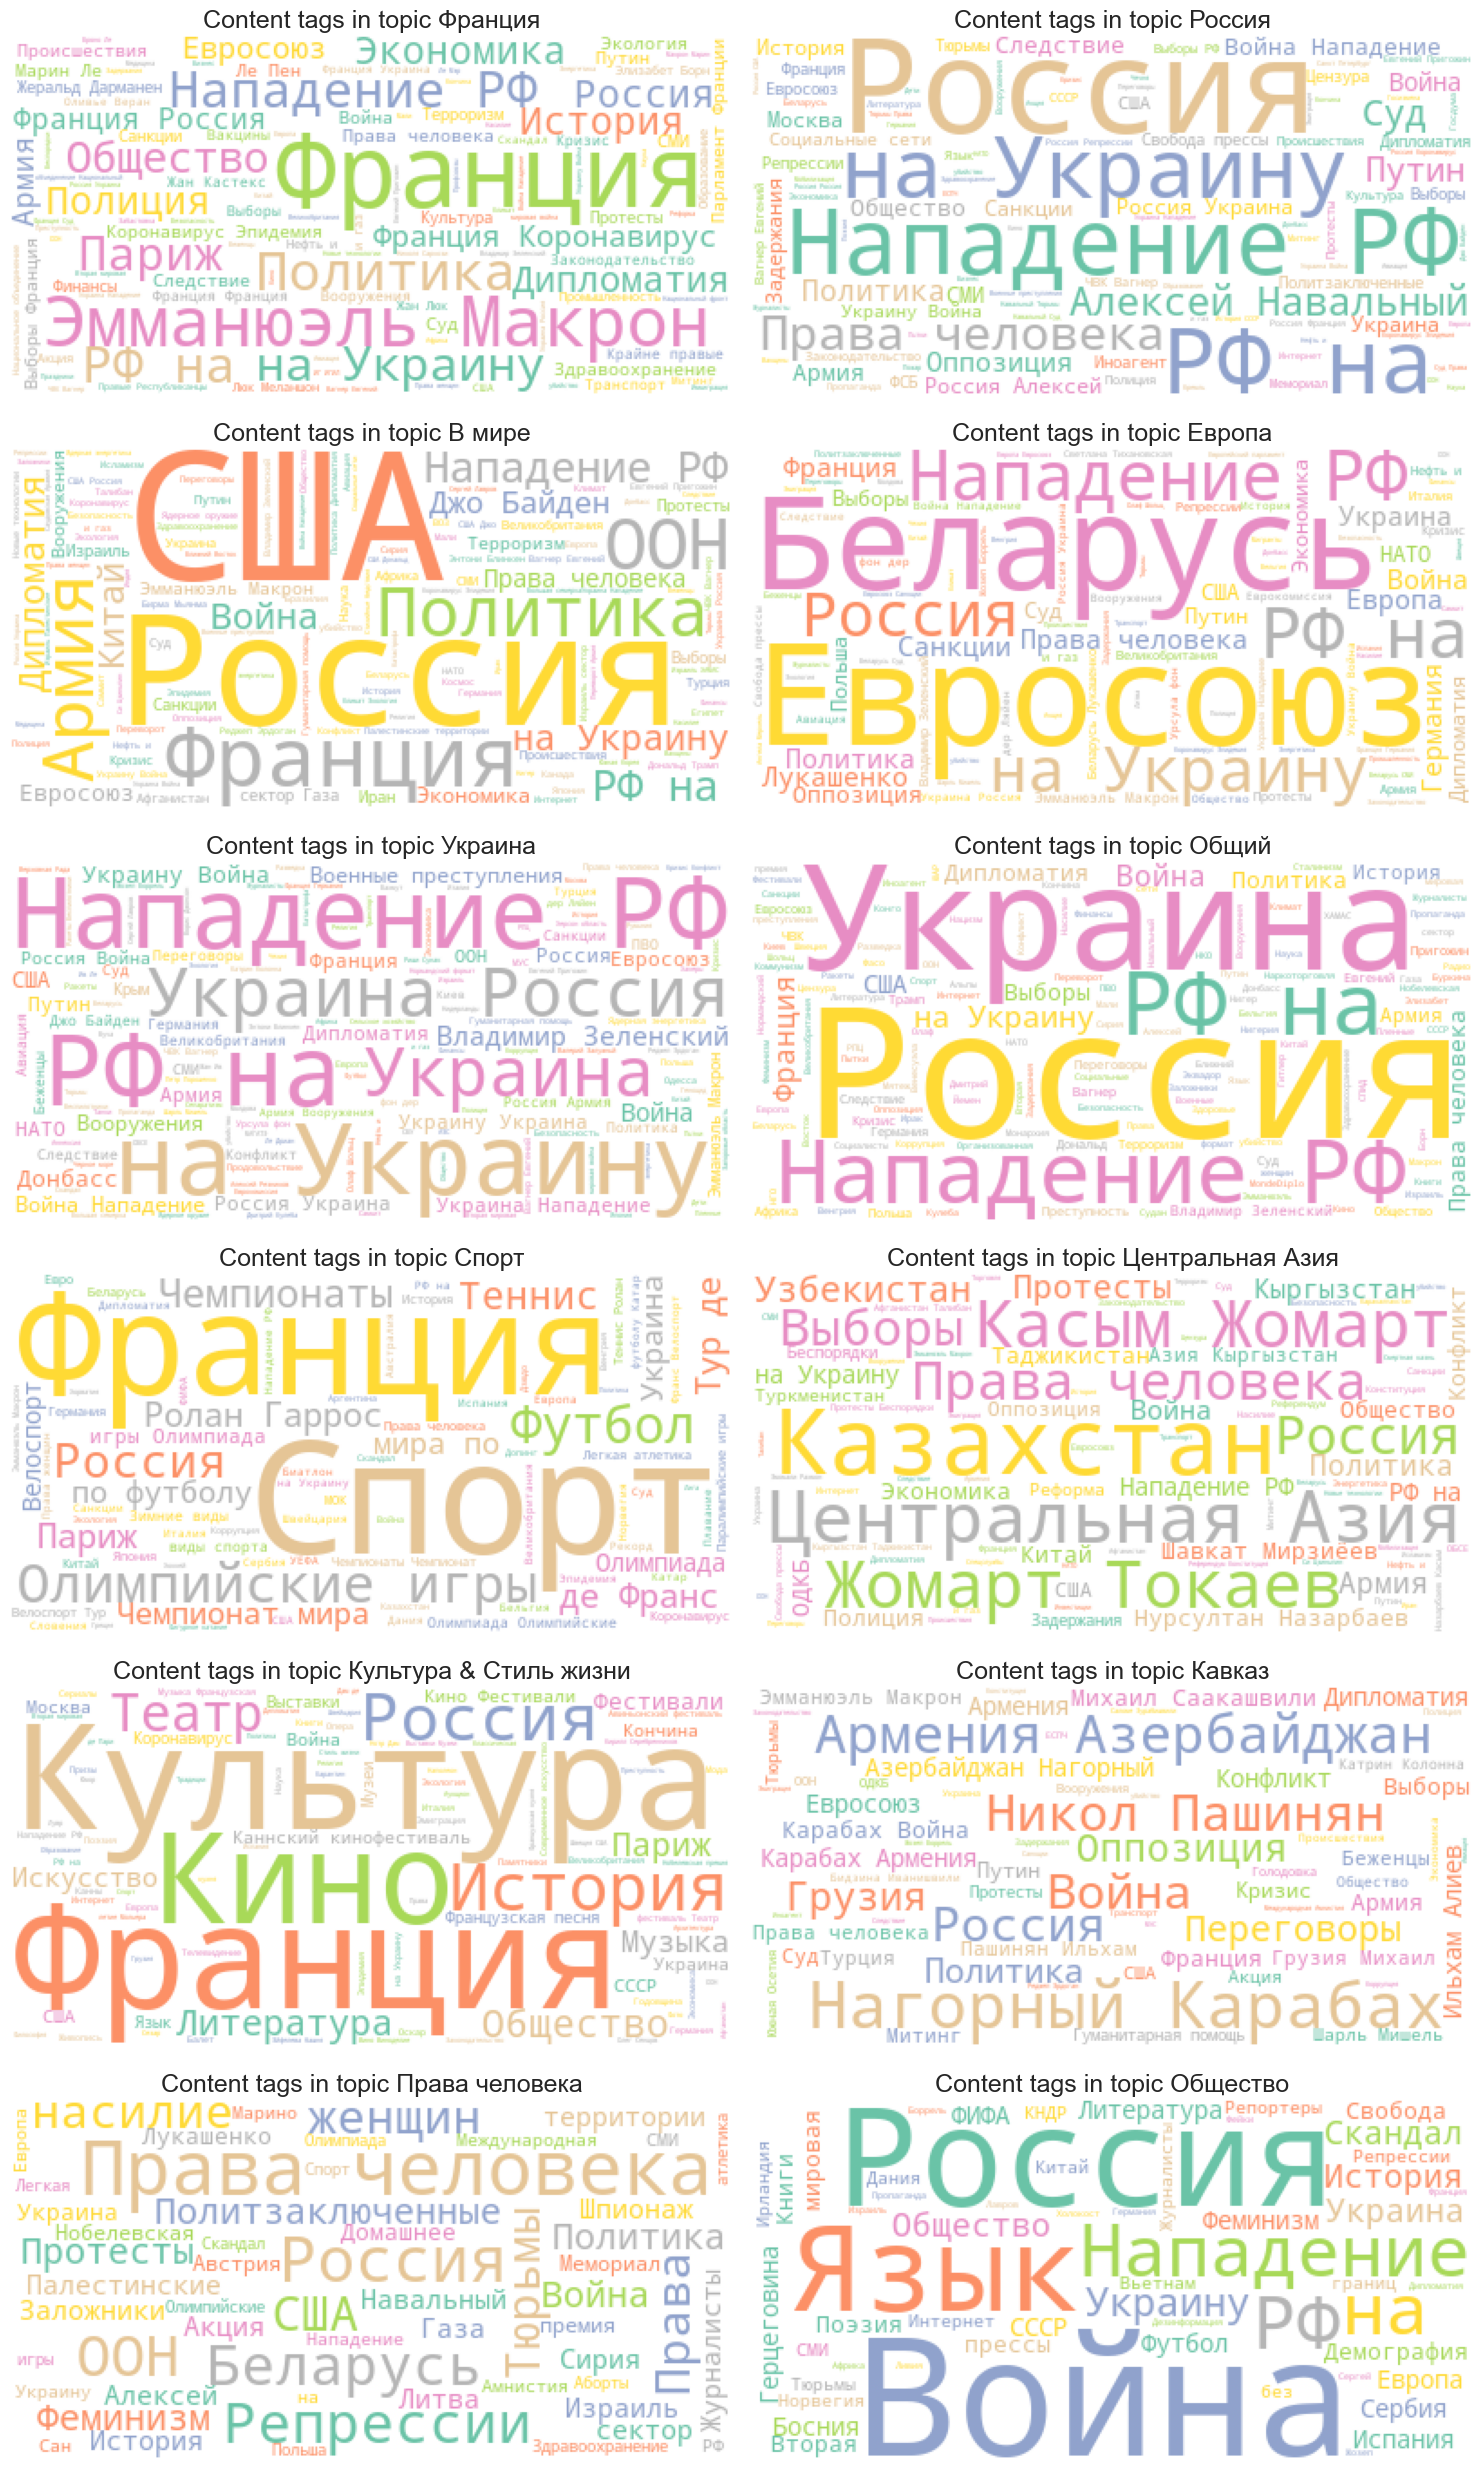

In [54]:
unique_topics = articles_full["topic"].unique()

num_rows = len(unique_topics) // 2 + len(unique_topics) % 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 25))

for i, topic in enumerate(unique_topics):
    tags = (
        articles_full[articles_full["topic"] == topic]["content_tags"].explode().values
    )

    wc = WordCloud(background_color="white", colormap="Set2")
    wc.generate(" ".join(tags))

    row = i // 2
    col = i % 2

    axes[row, col].imshow(wc, alpha=0.98)
    axes[row, col].set_title(f"Content tags in topic {topic}", fontsize=18)
    axes[row, col].axis("off")

if len(unique_topics) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout();

______
__Распределение тегов по категориям__
> Визуализация ключевых слов по каждому тематическому разделу показывает, что существуют общие теги, которые встречаются в разных категориях категорий. Однако их частотность разная в разных категориях.

> В малых тематических категориях (*Общество*, *Общий*, *Права человека*), которые представлены менее, чем 1% статей, можно выделить ключевые слова, связанные с различными более крупными категориями. Это означает,что их объединение с какой-то конкретной крупной категорией может быть непродуктивным, вероятно, еще больше усложнит их классификацию.

### __reading_time__: Время чтения статьи

Из непропущенных строковых значений с указанием количества минут, необходимых для прочтения статьи, создаем целочисленный признак.

In [55]:
articles_full["reading_time"] = (
    articles_full["reading_time"][pd.notna(articles_full["reading_time"]) == True]
    .str.extract("(\d+)")
    .astype(int)
)

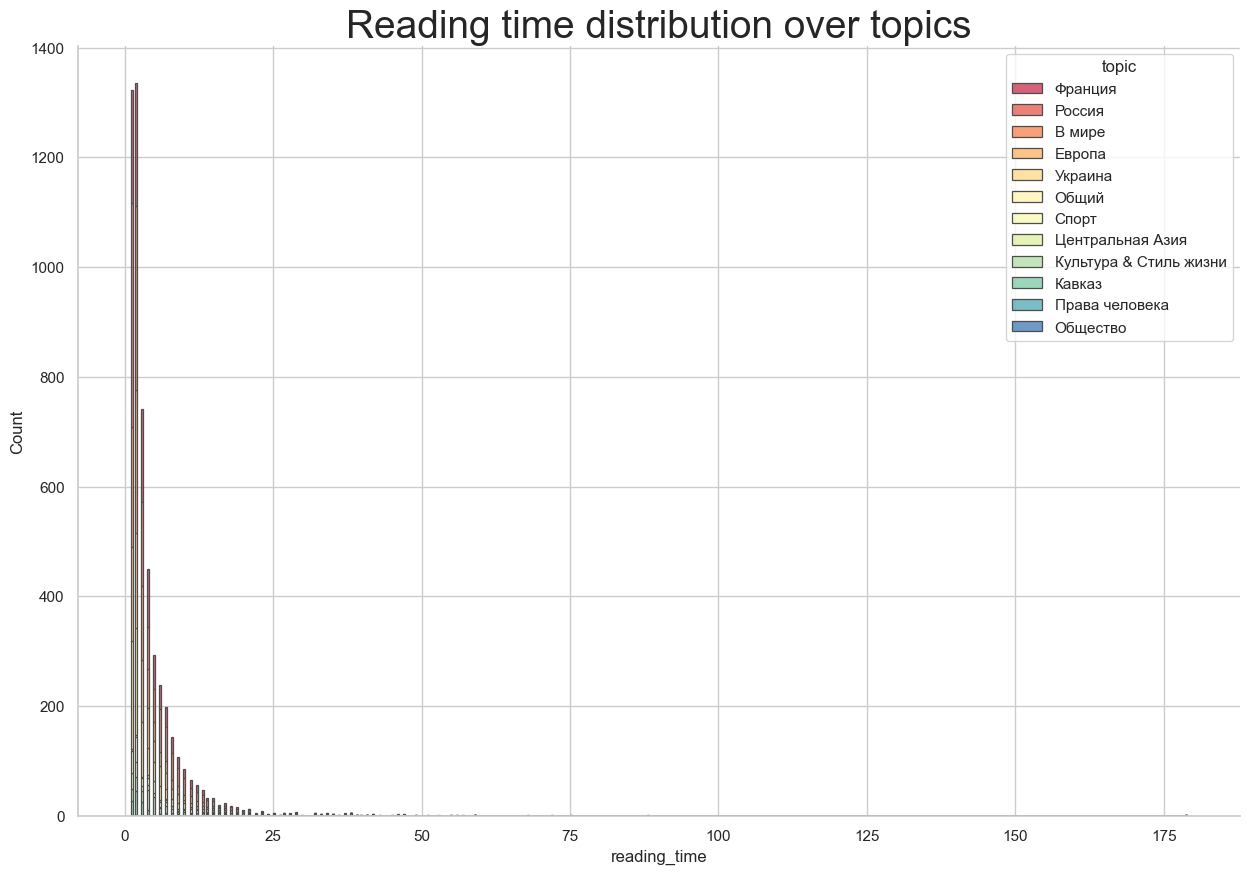

In [56]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10), dpi=100)
sns.despine(fig)

hist = sns.histplot(
    articles_full,
    x="reading_time",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="Spectral",
    linewidth=0.9,
)
hist.axes.set_title("Reading time distribution over topics", fontsize=28);

_____
Распределение времени чтения статей демонстрирует сильный скос.Очень тяжелый хвост распределения указывает на наличие выбросов и аномально больших значений признака. При расчете предположительного времени чтения статьи обычно учитывается и время на просмотр иллюстративного материала к тексту, однако значения признака приближающиеся к 3 часам скорее всего являются аномальными.

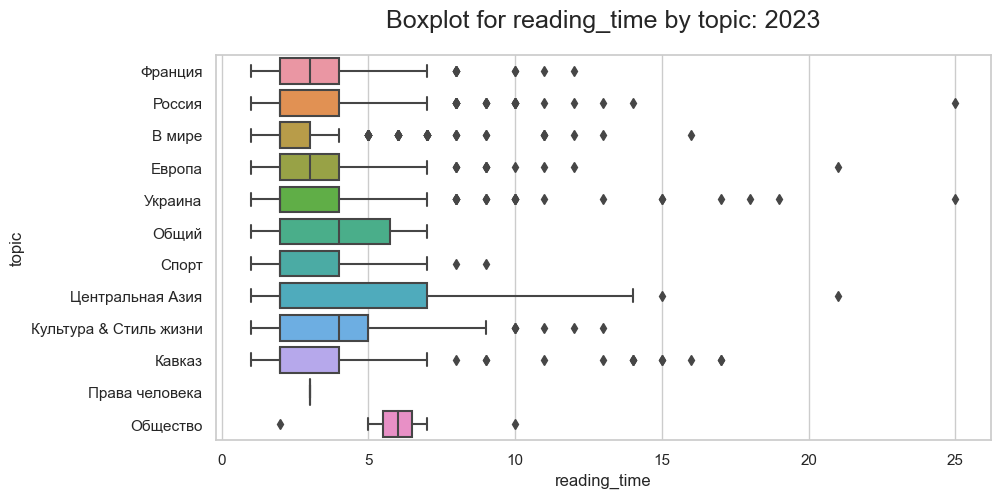

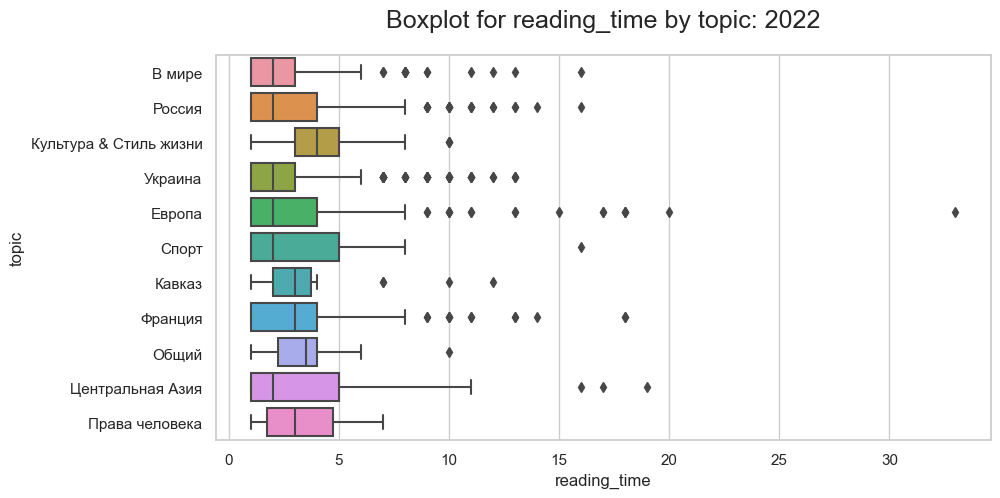

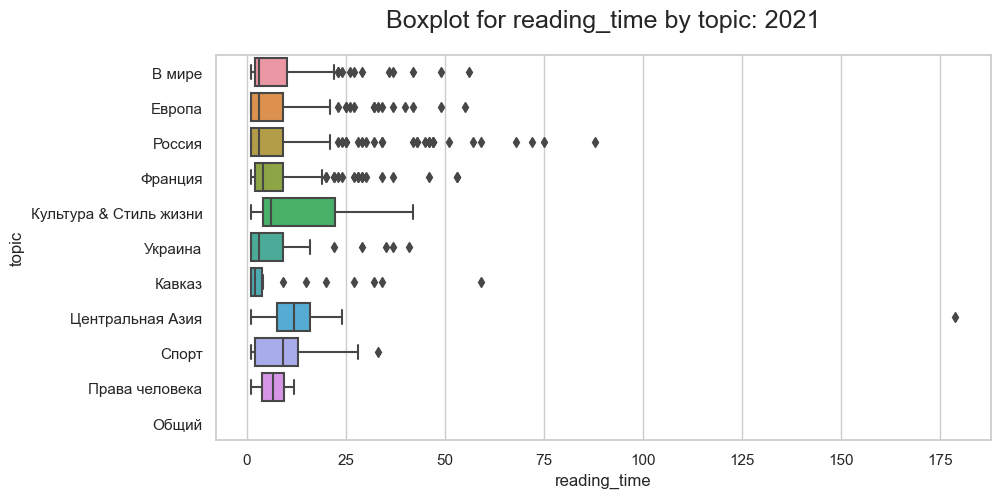

In [57]:
for df, year in zip(dfs, years):
    df["reading_time"] = (
        df["reading_time"][pd.notna(df["reading_time"]) == True]
        .str.extract("(\d+)")
        .astype(int)
    )
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
    sns.boxplot(x="reading_time", y="topic", data=df, orient="h", ax=ax)
    plt.title(f"Boxplot for reading_time by topic: {year}", fontsize=18, pad=20);

__________
__Распределение времени чтения статьи__

> Аномальные значения признака `reading_time` характерны для данных за 2021 год. Именно в 2021 году на страницах статей на сайте появляется указание на предполагаемое время чтения, и в данных за этот год было отмечено больше всего пропусков.

>Наибольшее сходство в распределениях времени чтения статей по разным темам наблюдается в 2023 году.

> 2022 и 2023 годы имеют схожий диапазон значений времени чтения, включая значения, отмеченные как выбросы.

__Заполнение пропусков в столбце `reading_time`__

- Попробуем предсказывать время прочтения статьи по признакам `body_toks` и `body_chars` — сумме токенов и сумме символов в вводном абзаце и основном тексте статьи

- Для предсказания времени чтения статьи обучаем и оптимизируем модель *RandomForestRegressor*

- Обучающую выборку формируем из данных за 2023 и 2022 год

In [258]:
df = articles_full[
    (articles_full["reading_time"].isna() == False)
    & (articles_full["year"].isin(["2023", "2022"]))
]
df["body_toks"] = df["full_text_toks"] + df["summary_toks"]
df["body_chars"] = df["full_text_chars"] + df["summary_chars"]

X_23 = df.drop(columns=["reading_time"])[["body_toks", "body_chars"]]
y_23 = df["reading_time"]

X_train, X_test, y_train, y_test = train_test_split( X_23, y_23, test_size=0.25, random_state=8)

In [259]:
rf = RandomForestRegressor(random_state=8)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)

In [260]:
print('MAE:', mean_absolute_error(y_test, pred), '\nTarget mean:', np.mean(y_test))
pd.DataFrame({'true': y_test[:10], 'pred': pred[:10]})

MAE: 0.3899489076814658 
Target mean: 3.1300211416490487


true  pred
1507   3.0  2.79
1582   2.0  1.99
3648   1.0  1.01
584    5.0  5.69
15     1.0  1.00
3501   2.0  2.02
2703   2.0  2.00
552    1.0  1.24
397    2.0  2.04
119    3.0  2.75

RandomForestRegressor с параметрами по умолчанию в среднем ошибается в предсказаниях примерно на 23 секунды.

Настраиваем гиперпараметры:

- `n_estimators`: количество решающих деревьев в модели;
- `criterion`: функция качества разделения узлов;
- `max_depth`: максимальная глубина дерева;
- `min_samples_split`: минимальное количество объектов для разделения внутреннего узла.

In [261]:
params = {
    'n_estimators': [1, 3, 5, 10],
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [1, 3, 5, 10],
    'min_samples_split': [1, 3, 5, 10]
}

gs_rf = GridSearchCV(rf, params, scoring='neg_mean_absolute_error', cv=4, n_jobs=1, verbose=1)
gs_rf.fit(X_train, y_train)

Fitting 4 folds for each of 128 candidates, totalling 512 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=8), n_jobs=1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [1, 3, 5, 10],
                         'min_samples_split': [1, 3, 5, 10],
                         'n_estimators': [1, 3, 5, 10]},
             scoring='neg_mean_absolute_error', verbose=1)

In [262]:
gs_rf.best_estimator_, gs_rf.best_score_

(RandomForestRegressor(criterion='absolute_error', max_depth=5,
                       min_samples_split=3, n_estimators=5, random_state=8),
 -0.3057827926657264)

In [263]:
gs_pred = gs_rf.best_estimator_.predict(X_test)

In [264]:
print('MAE:', mean_absolute_error(y_test, gs_pred), '\nTarget mean:', np.mean(y_test))
pd.DataFrame({'true': y_test[40:50], 'pred': gs_pred[40:50]})

MAE: 0.2980972515856237 
Target mean: 3.1300211416490487


true  pred
3154   3.0   2.0
1931   2.0   2.0
3584   2.0   1.0
1721   5.0   5.0
2486   2.0   2.0
126    1.0   1.0
3416   7.0   6.0
2905   5.0   5.2
3784   2.0   2.0
423    2.0   2.0

После настройки гиперпараметров модель в среднем ошибается при предсказании примерно на 18 секунд, то есть средняя ошибка уменьшилась примерно на 5 секунд.

Посмотрим, какие результаты будет давать модель на данных за 2021 год.

In [265]:
df_21 = articles_full[(articles_full['reading_time'].notna()) & (articles_full['year'] == '2021')]
df_21['body_toks'] = df_21['full_text_toks'] + df_21['summary_toks']
df_21['body_chars'] = df_21['full_text_chars'] + df_21['summary_chars']

X_21 = df_21.drop(columns=['reading_time'])[['body_toks', 'body_chars']]
y_21 = df_21['reading_time']

pred_21 = gs_rf.best_estimator_.predict(X_21)

In [276]:
print('MAE:', mean_absolute_error(y_21, pred_21), '\nTarget mean:', np.mean(y_21))
pd.DataFrame({'true': y_21[40:50], 'pred': pred_21[40:50]})

MAE: 5.197530082330589 
Target mean: 7.550981633945535


true  pred
3884   3.0   3.0
3885   4.0   4.0
3886   2.0   2.0
3887   6.0   6.6
3888   2.0   2.0
3889  16.0  17.5
3890   9.0   9.8
3891   1.0   1.0
3892   1.0   1.0
3893   2.0   2.0

На данных за 2021 год средняя ошибка модели очень большая. В среднем предсказания откланяются от реальных значений больше чем на 5 минут, при этом среднее значение по выборке примерно 7,5 минут. Однако сравнение нескольких примеров предсказаний с реальными значениями выглядит достаточно адекватно. Возможно, очень большая ошибка связана с отмеченными ранее в данных аномальными значениями.

Заполним пропущенные значения и значения столбца `reading_time` за 2021 год предсказаниями модели, округленными до целого количества минут.

In [277]:
updated_data = articles_full[
    (
        (articles_full["reading_time"].notna() == False)
        & (articles_full["year"].isin(["2023", "2022"]))
    )
    | (articles_full["year"] == "2021")
]


updated_data["body_toks"] = (
    updated_data["full_text_toks"] + updated_data["summary_toks"]
)
updated_data["body_chars"] = (
    updated_data["full_text_chars"] + updated_data["summary_chars"]
)

X = updated_data.drop(columns=["reading_time"])[["body_toks", "body_chars"]]

pred = gs_rf.best_estimator_.predict(X)


indices = X.index.to_numpy()

updated_data.loc[indices, "reading_time"] = np.round(pred)

In [278]:
articles_full_copy = articles_full.copy()

inds = updated_data.index.to_numpy()
articles_full_copy.loc[inds, 'reading_time'] = updated_data['reading_time']

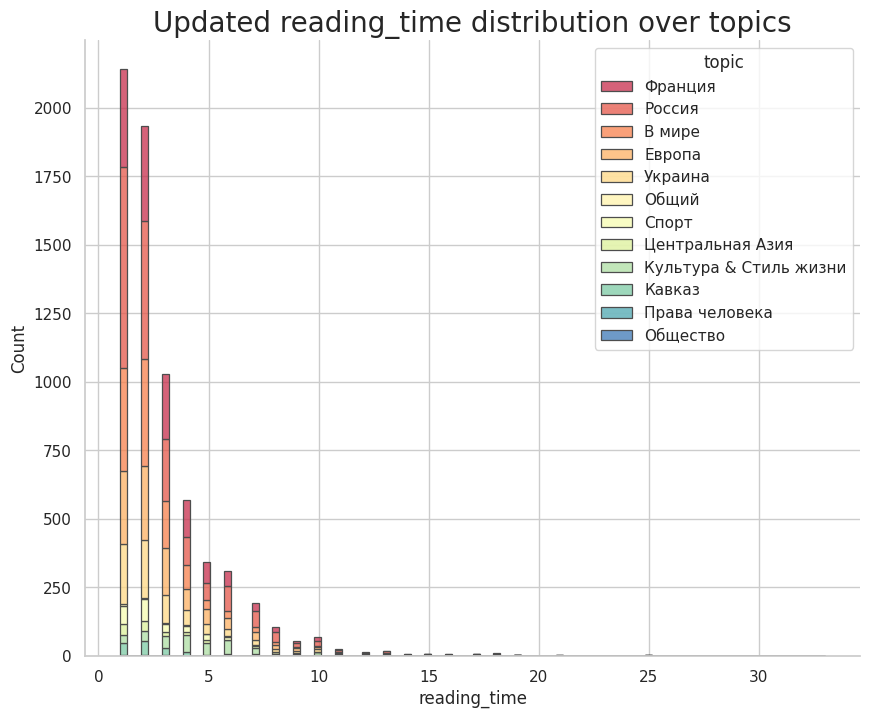

In [279]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
sns.despine(fig)

hist = sns.histplot(
    articles_full_copy,
    x="reading_time",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="Spectral",
    linewidth=0.9,
)
hist.axes.set_title("Updated reading_time distribution over topics", fontsize=20);

________
__Распределение обновленных данных по времени чтения статьи__

> Распределение обновленных значений времени чтения демонстрирует сильный скос. Это ожидаемо, учитывая, что схожую форму имеет распределение длины основного текста.

> В распределении времени чтения статьи есть значительное количество выбросов, но после обновления данных хвост распределения стал менее тяжелым. Максимальное значение показателя — 33 минуты.

### Итоги первого этапа предобработки и анализа данных

- датасет содержит информацию о __6857 объектах__;

- в полученном датасете отсутствуют пропуски;

- на основе исходных атрибутов объектов в данные были добавлены __10 новых признаков__: 7 числовых признаков (`title_toks`, `title_chars`, `summary_toks`, `summary_chars`, `full_text_toks`, `full_text_chars`, `num_content_tags`) и 3 категориальных признака (`year`, `month`, `weekday`).

In [332]:
articles_full_copy.shape

(6857, 18)

In [333]:
articles_full_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6857 entries, 0 to 6885
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   url               6857 non-null   object             
 1   topic             6857 non-null   object             
 2   title             6857 non-null   object             
 3   summary           6857 non-null   object             
 4   full_text         6857 non-null   object             
 5   pub_datetime      6857 non-null   datetime64[ns, UTC]
 6   reading_time      6857 non-null   float64            
 7   content_tags      6857 non-null   object             
 8   title_toks        6857 non-null   int64              
 9   title_chars       6857 non-null   int64              
 10  summary_toks      6857 non-null   int64              
 11  summary_chars     6857 non-null   int64              
 12  full_text_toks    6857 non-null   int64              
 13  ful

In [319]:
articles_full_copy.sample(3)

url    topic  \
3176  https://www.rfi.fr/ru/франция/20220319-конец-в...  Франция   
3930  https://www.rfi.fr/ru/в-мире/20211218-талибы-о...   В мире   
6185  https://www.rfi.fr/ru/франция/20210327-второму...  Франция   

                                                  title  \
3176  Конец войны: 60 лет назад Франция и Алжир подп...   
3930  Талибы объявили о возобновлении выдачи паспорт...   
6185  Второму подозреваемому по делу об убийстве вых...   

                                                summary  \
3176  Ровно 60 лет назад закончилась многолетняя вой...   
3930  Захватившее в конце лета власть в Афганистане ...   
6185  По делу об убийстве выходца из Чечни во францу...   

                                              full_text  \
3176  Война началась в ночь на 1 ноября 1954 года, к...   
3930  Талибы объявили, что этот процесс начнется в в...   
6185  Обвинение в соучастии в убийстве в составе пре...   

                  pub_datetime  reading_time  \
3176 2022-03-19 14:27:37+00:00           6.0   
3930 2021-12-18 14:39:15+00:00           1.0   
6185 2021-03-27 17:20:10+00:00           5.0   

                                           content_tags  title_toks  \
3176  [Франция, Алжир, История, Война, Эмманюэль Мак...          11   
3930  [Афганистан, Талибан, Права человека, Голод, ООН]           8   
6185  [Происшествия, Чечня, Наркоторговля, Франция, ...          13   

      title_chars  summary_toks  summary_chars  full_text_toks  \
3176           61            64            396             884   
3930           55            35            199             122   
6185           79            63            392             825   

      full_text_chars  year     month   weekday  num_content_tags  
3176             5828  2022     March  Saturday                 5  
3930              721  2021  December  Saturday                 5  
6185             4971  2021     March  Saturday                 6

> Датасет содержит информацию о статьях за 3 года (2023, 2022,2021), с более чем 40% публикаций, которые относятся к 2021 году. Объекты в датасете неравномерно распределены по тематическим разделам (`topic`). В данных есть 5 наиболее крупных разделов, которые включают более 80% всех статей.

> Заголовки статей, как и лид-абзацы, достаточно единообразны по количеству токенов и символов. В распределениях этих признаков есть выбросы, но распределения довольно близки к нормальному. 

> В основном датасет включает небольшие статьи (в среднем до 500 токенов в основном тексте). Тем не менее распределение количества токенов в основном тексте имеет значительное количество отклонений в большую сторону от среднего значения. Кроме того, в данных есть объекты с очень небольшими значениями длины основного текста (менее 100 токенов), которые остались после фильтрации нетекстового контента.

> Анализ списков тегов к статьям указывает на наличие множества пересечений ключевых слов в статьях различных тематических категорий. Однако следует отметить, что степень встречаемости одних и тех же тегов в разных категориях различается.